# Alzheimer textual explanation, visual explanation and classification
In this notebook there's all the procedure we do for the classification and for the explanation.

For the realization of this project i start from the code of my colleague.

In this notebook we suppose that you have already the dataset and the explanation, if else, 
you will run "Creation of the dataset" before this notebook.

In [1]:
import os, random, glob, cv2
import nltk
 
import pickle

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sys import platform
import re
import html
import string
import unicodedata
from nltk.tokenize import word_tokenize
import os

from sklearn.preprocessing import MinMaxScaler
from torch import nn
from tqdm.notebook import tqdm

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences, to_categorical, plot_model 

from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Input, Dense,
    LSTM, Embedding,
    Dropout, add,
    MaxPool3D, Conv3D,
    GlobalAveragePooling3D, BatchNormalization
)

import torch
from torch.utils.data import Dataset, DataLoader

import importlib
import Utility
importlib.reload(Utility)
from Utility import get_gradcam
from alzheimer_disease.src.helpers.utils import get_device
from alzheimer_disease.src.modules.training import training_model
from alzheimer_disease.src.helpers.config import get_config
from alzheimer_disease.src.modules.preprocessing import get_transformations
from alzheimer_disease.src.models.densenetmm import DenseNetMM

#nltk.download('punkt')

In [2]:
# Definition of all paths
dataset = 'oasis_aug'

_base_path = '/Volumes/Seagate Bas/Vito/CV'
_config = get_config()
saved_path = os.path.join(_base_path, _config.get('SAVED_FOLDER'))
reports_path = os.path.join(_base_path, _config.get('REPORT_FOLDER'))
logs_path = os.path.join(_base_path, _config.get('LOG_FOLDER'))
_data_path = os.path.join(_base_path, _config.get('LOCAL_DATA'))
data_path, meta_path, explanation_path = [
    os.path.join(_data_path, dataset, 'data/'),
    os.path.join(_data_path, dataset, 'meta/'),
    os.path.join(_data_path, dataset, 'explainability/')
]

device = get_device()

if platform == 'win32':
    saved_path = saved_path.replace('/', '\\')
    reports_path = reports_path.replace('/', '\\')
    logs_path = logs_path.replace('/', '\\')
    data_path = data_path.replace('/', '\\')
    meta_path = meta_path.replace('/', '\\')
    explanation_path = explanation_path.replace('/', '\\')

saved_path, reports_path, logs_path, data_path, meta_path, explanation_path, device

('/Volumes/Seagate Bas/Vito/CV/saved/',
 '/Volumes/Seagate Bas/Vito/CV/reports/',
 '/Volumes/Seagate Bas/Vito/CV/logs/',
 '/Volumes/Seagate Bas/Vito/CV/data/oasis_aug/data/',
 '/Volumes/Seagate Bas/Vito/CV/data/oasis_aug/meta/',
 '/Volumes/Seagate Bas/Vito/CV/data/oasis_aug/explainability/',
 'cpu')

In [3]:
SIZE = 128
output_length = 1024
epochs = 30
name_model = 'DenseNetMM_best'

CHANNELS = ['T2w']

FEATURES = ['sex', 'age', 'bmi', 'education', 'cdr_memory', 'cdr_orientation', 'cdr_judgment', 'cdr_community', 'cdr_hobbies', 'cdr_personalcare', 'boston_naming_test', 'depression', 'sleeping_disorder', 'motor_disturbance']
MULTICLASS = True

In [4]:
# I started with the train test split of colleague and adapt to my task
def train_test_splitting(
        data_folder,
        meta_folder,
        explanation_folder,
        channels,
        features,
        train_ratio=.8,
        multiclass=False,
        verbose=True
):
    """
    Splitting train/eval/test.
    Args:
        data_folder (str): path of the folder containing images.
        meta_folder (str): path of the folder containing csv files.
        explanation_folder (str): path of the folder containing csv files of the explanation.
        channels (list): image channels to select (values `T1w`, `T2w` or both).
        features (list): features set to select.
        train_ratio (float): ratio of the training set, value between 0 and 1.
        multiclass (bool): `False` for binary classification, `True` for ternary classification.
        verbose (bool): whether or not print information.
    Returns:
        train_data (list): the training data ready to feed monai.data.Dataset
        eval_data (list): the evaluation data ready to feed monai.data.Dataset
        test_data (list): the testing data ready to feed monai.data.Dataset.
        (see https://docs.monai.io/en/latest/data.html#monai.data.Dataset).
    """
    scaler = MinMaxScaler()
    df = pd.read_csv(os.path.join(meta_folder, 'data_num.csv'))
    df1 = df[(df['weight'] != .0) & (df['height'] != .0)]
    df['bmi'] = round(df1['weight'] / (df1['height'] * df1['height']), 0)
    df['bmi'] = df['bmi'].fillna(.0)
    sessions = [s.split('_')[0] for s in os.listdir(data_folder) if os.path.isdir(os.path.join(data_folder, s))]
    subjects = list(set(sessions))

    # uploading of the dataset
    explanation = pd.read_csv(explanation_folder + 'explaination.csv', sep=';')



    # applying splitting on subjects to prevent data leakage
    random.shuffle(subjects)
    split_train = int(len(subjects) * train_ratio)
    train_subjects, test_subjects = subjects[:split_train], subjects[split_train:]
    split_eval = int(len(train_subjects) * .8)
    eval_subjects = train_subjects[split_eval:]
    train_subjects = train_subjects[:split_eval]

    # applying multiclass label correction and splitting
    if multiclass:
        train_subjects, eval_subjects, test_subjects = [], [], []
        df.loc[df['cdr'] == .0, 'final_dx'] = .0
        df.loc[df['cdr'] == .5, 'final_dx'] = 1.
        df.loc[(df['cdr'] != .0) & (df['cdr'] != .5), 'final_dx'] = 2.
        m = np.min(np.unique(df['final_dx'].to_numpy(), return_counts=True)[1])
        df = pd.concat([
            df[df['final_dx'] == .0].sample(m),
            df[df['final_dx'] == 1.].sample(m),
            df[df['final_dx'] == 2.].sample(m)
        ], ignore_index=True)
        n_test = m - int(m * train_ratio)
        n_eval = m - n_test - int(m * train_ratio * train_ratio)
        for i in range(3):
            sub = list(set(df[df['final_dx'] == float(i)]['subject_id'].to_numpy()))
            random.shuffle(sub)
            counter = 0
            for j in range(len(sub)):
                counter += len(df[df['subject_id'] == sub[j]])
                if counter <= n_test:
                    test_subjects.append(sub[j])
                elif counter > n_test and counter <= (n_test + n_eval):
                    eval_subjects.append(sub[j])
                else:
                    train_subjects.append(sub[j])

    # loading sessions paths
    X_train = df[df['subject_id'].isin(train_subjects)]
    X_eval = df[df['subject_id'].isin(eval_subjects)]
    X_test = df[df['subject_id'].isin(test_subjects)]
    train_sessions = [os.path.join(data_folder, s) for s in X_train['session_id'].values]
    eval_sessions = [os.path.join(data_folder, s) for s in X_eval['session_id'].values]
    test_sessions = [os.path.join(data_folder, s) for s in X_test['session_id'].values]

    # loading explanation of subjects
    explanation_train = explanation[explanation['subject_id'].isin(X_train['subject_id'].values)]
    explanation_eval = explanation[explanation['subject_id'].isin(X_eval['subject_id'].values)]
    explanation_test = explanation[explanation['subject_id'].isin(X_test['subject_id'].values)]

    # scaling numerical data in range [0,1]
    X_train.loc[:, features] = scaler.fit_transform(X_train[features])
    X_eval.loc[:, features] = scaler.fit_transform(X_eval[features])
    X_test.loc[:, features] = scaler.fit_transform(X_test[features])

    # arranging data in dictionaries
    # I will also take the reference session of the explanation and the image
    train_data = [dict({
        'image': sorted([os.path.join(s, i) for i in os.listdir(s) if any(c in i for c in channels)]),
        'data': X_train[X_train['session_id'] == s.split('/')[-1]][features].values[0],
        'label': df[df['session_id'] == s.split('/')[-1]]['final_dx'].values[0],
        'explanation': explanation_train[explanation_train['session_id'] == s.split('/')[-1]]['explaination'].values[0],
        'session_id': s.split('/')[-1]
    }) for s in train_sessions]
    eval_data = [dict({
        'image': sorted([os.path.join(s, i) for i in os.listdir(s) if any(c in i for c in channels)]),
        'data': X_eval[X_eval['session_id'] == s.split('/')[-1]][features].values[0],
        'label': df[df['session_id'] == s.split('/')[-1]]['final_dx'].values[0],
        'explanation': explanation_eval[explanation_eval['session_id']==s.split('/')[-1]]['explaination'].values[0],
        'session_id': s.split('/')[-1]
    }) for s in eval_sessions]
    test_data = [dict({
        'image': sorted([os.path.join(s, i) for i in os.listdir(s) if any(c in i for c in channels)]),
        'data': X_test[X_test['session_id'] == s.split('/')[-1]][features].values[0],
        'label': df[df['session_id'] == s.split('/')[-1]]['final_dx'].values[0],
        'explanation': explanation_test[explanation_test['session_id'] == s.split('/')[-1]]['explaination'].values[0],
        'session_id': s.split('/')[-1]
    }) for s in test_sessions]

    # print data splitting information
    if verbose:
        print(''.join(['> ' for _ in range(40)]))
        print(f'\n{"":<20}{"TRAINING":<20}{"EVALUATION":<20}{"TESTING":<20}\n')
        print(''.join(['> ' for _ in range(40)]))
        tsb1 = str(len(train_subjects)) + ' (' + str(round((len(train_subjects) * 100 / len(df['subject_id'].unique())), 0)) + ' %)'
        tsb2 = str(len(eval_subjects)) + ' (' + str(round((len(eval_subjects) * 100 / len(df['subject_id'].unique())), 0)) + ' %)'
        tsb3 = str(len(test_subjects)) + ' (' + str(round((len(test_subjects) * 100 / len(df['subject_id'].unique())), 0)) + ' %)'
        tss1 = str(len(train_sessions)) + ' (' + str(round((len(train_sessions) * 100 / len(df)), 2)) + ' %)'
        tss2 = str(len(eval_sessions)) + ' (' + str(round((len(eval_sessions) * 100 / len(df)), 2)) + ' %)'
        tss3 = str(len(test_sessions)) + ' (' + str(round((len(test_sessions) * 100 / len(df)), 2)) + ' %)'
        print(f'\n{"subjects":<20}{tsb1:<20}{tsb2:<20}{tsb3:<20}\n')
        print(f'{"sessions":<20}{tss1:<20}{tss2:<20}{tss3:<20}\n')

    return train_data, eval_data, test_data

In [5]:
densenet = DenseNetMM(
    in_channels = len(CHANNELS),
    in_size = SIZE,
    in_features_size= len(FEATURES),
    out_channels = 3 if MULTICLASS else 2,
    append_features = True,
    name=name_model
)

In [6]:
train_transform, eval_transform = get_transformations(size=SIZE)

train, val, test = train_test_splitting(
    data_folder=data_path,
    meta_folder=meta_path,
    explanation_folder=explanation_path,
    channels=CHANNELS,
    features=FEATURES,
    multiclass=MULTICLASS,
    verbose=True
)

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

                    TRAINING            EVALUATION          TESTING             

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

subjects            369 (63.0 %)        94 (16.0 %)         120 (21.0 %)        

sessions            435 (63.6 %)        111 (16.23 %)       138 (20.18 %)       



In [7]:
train[0]

{'image': ['/Volumes/Seagate Bas/Vito/CV/data/oasis_aug/data/OAS30387_MR_d3401/sub-OAS30387_ses-d3401_acq-TSE_T2w.nii.gz'],
 'data': array([0.        , 0.77083333, 0.58490566, 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.98333333, 0.5       , 0.5       , 0.5       ]),
 'label': 0.0,
 'explanation': "**Summary of Heatmap Analysis**\n\nThe heatmap analysis reveals that the AI model focused on specific regions of the brain to make its classification decision. The highlighted regions are not areas affected by Alzheimer's Disease, but rather areas that the model considered crucial for its diagnosis. The following regions were identified:\n\n1. **Frontal-to-Occipital (GapMap) left**: This region accounts for 19.9% of the heatmap and 17.81% of the region affected. The GapMap is a region that connects the frontal and occipital lobes, playing a crucial role in attention, memory, and language processing. The model's focus on this region ma

In [8]:
if glob.glob(saved_path+ f'{name_model}.pth'):
	print(f'Loading {name_model}.pth')
	densenet.load_state_dict(torch.load(saved_path + f'{name_model}.pth'))
else:
	print('Train of the model')
	train_metrics = training_model(
		model = densenet,
		data = [train, val],
		transforms = [train_transform, eval_transform],
		epochs = epochs,
		device = get_device(),
		paths = [saved_path, reports_path, logs_path],
		num_workers=0,
		verbose=True
	)

Loading DenseNetMM_best.pth


## Image Captioning

In [9]:
name_fextractor = 'DenseNetMMFeatureExtractor'

In [15]:
from monai.data import CacheDataset


def remove_special_chars(text):
    re1 = re.compile(r'  +')
    x1 = text.lower().replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\n', "\n").replace('quot;', "'").replace(
        '', "\n").replace('\"', '"').replace('', 'u_n').replace(' @.@ ', '.').replace(
        ' @-@ ', '-').replace('\'', ' \ ')
    return re1.sub(' ', html.unescape(x1))


def remove_non_ascii(text):
    """Remove non-ASCII characters from list of tokenized words"""
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')


def to_lowercase(text):
    return text.lower()

def remove_punctuation(text):
    """Remove punctuation from list of tokenized words"""
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)


def replace_numbers(text):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    return re.sub(r'\d+', '', text)


def remove_whitespaces(text):
    return text.strip()


def remove_stopwords(words, stop_words):
    """
    :param words:
    :type words:
    :param stop_words: from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
    or
    from spacy.lang.en.stop_words import STOP_WORDS
    :type stop_words:
    :return:
    :rtype:
    """
    return [word for word in words if word not in stop_words]

def addsequences(text):
  return '' .join('startseq ' + " ".join([word for word in text.split() if len(word)>1]) + ' endseq')

def text2words(text):
    return word_tokenize(text)

def normalize_text( text):
    #text = remove_special_chars(text)
    text = remove_non_ascii(text)
    text = remove_punctuation(text)
    text = to_lowercase(text)
    text = replace_numbers(text)
    text = addsequences(text)
    return text
  
def normalize_corpus(corpus):
    return [normalize_text(t) for t in corpus]

def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# concat for get all df
entire_df = train + val + test

all_text = [explaination['explanation'] for explaination in entire_df]

# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(list(all_text))
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: {}'.format(vocab_size))

Vocabulary Size: 1175


In [10]:
feature_extractor = DenseNetMM(
    in_channels = len(CHANNELS),
    in_size = SIZE,
    in_features_size= len(FEATURES),
    out_channels = 3 if MULTICLASS else 2,
    append_features = True,
    name=name_fextractor
)

# Upload the previous model for the feature extraction
if glob.glob(saved_path+ f'{name_model}.pth'):
	print(f'Loading {name_model}.pth')
	feature_extractor.load_state_dict(torch.load(saved_path + f'{name_model}.pth'))
else:
	print('Train of the model')
	train_metrics = training_model(
		model = feature_extractor,
		data = [train, val],
		transforms = [train_transform, eval_transform],
		epochs = epochs,
		device = get_device(),
		paths = [saved_path, reports_path, logs_path],
		num_workers=0,
		verbose=True
	)
    
# get just the feature extractor from image

Loading DenseNetMM_best.pth


In [11]:
feature_extractor = torch.nn.Sequential(
    feature_extractor.features_img,
    feature_extractor.output_layers,
    #nn.Linear(1024, 256)
)

feature_extractor

Sequential(
  (0): Sequential(
    (conv0): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
    (norm0): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (layers): Sequential(
          (norm1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv3d(64, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
          (norm2): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv3d(128, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        )
      )
      (denselayer2): _DenseLayer(
        (layers): Sequential(
         

In [12]:
cache_entire_df = CacheDataset(entire_df, transform=train_transform, cache_rate=1.0, num_workers=None, progress=False)
entire_df_loader = DataLoader(cache_entire_df, batch_size=1, shuffle=False, num_workers=0)

NameError: name 'CacheDataset' is not defined

In [ ]:
# extract features from image
features = {}

for img_name in tqdm(entire_df_loader):
    image, val_inputs_data, session_id  = (
        img_name['image'],
        img_name['data'],
        img_name['session_id']
    )
    # extract features
    feature = feature_extractor(image)
    # store feature
    features[session_id[0]] = feature[0]

  0%|          | 0/684 [00:00<?, ?it/s]

In [ ]:
pickle.dump(features, open(os.path.join(saved_path, 'clef_features_vgg.pkl'), 'wb'))

In [16]:
if glob.glob(saved_path + 'clef_features_vgg.pkl'):
    with open(os.path.join(saved_path, 'clef_features_vgg.pkl'), 'rb') as f:
        print('Loading clef_features_vgg.pkl')
        features = pickle.load(f)

Loading clef_features_vgg.pkl


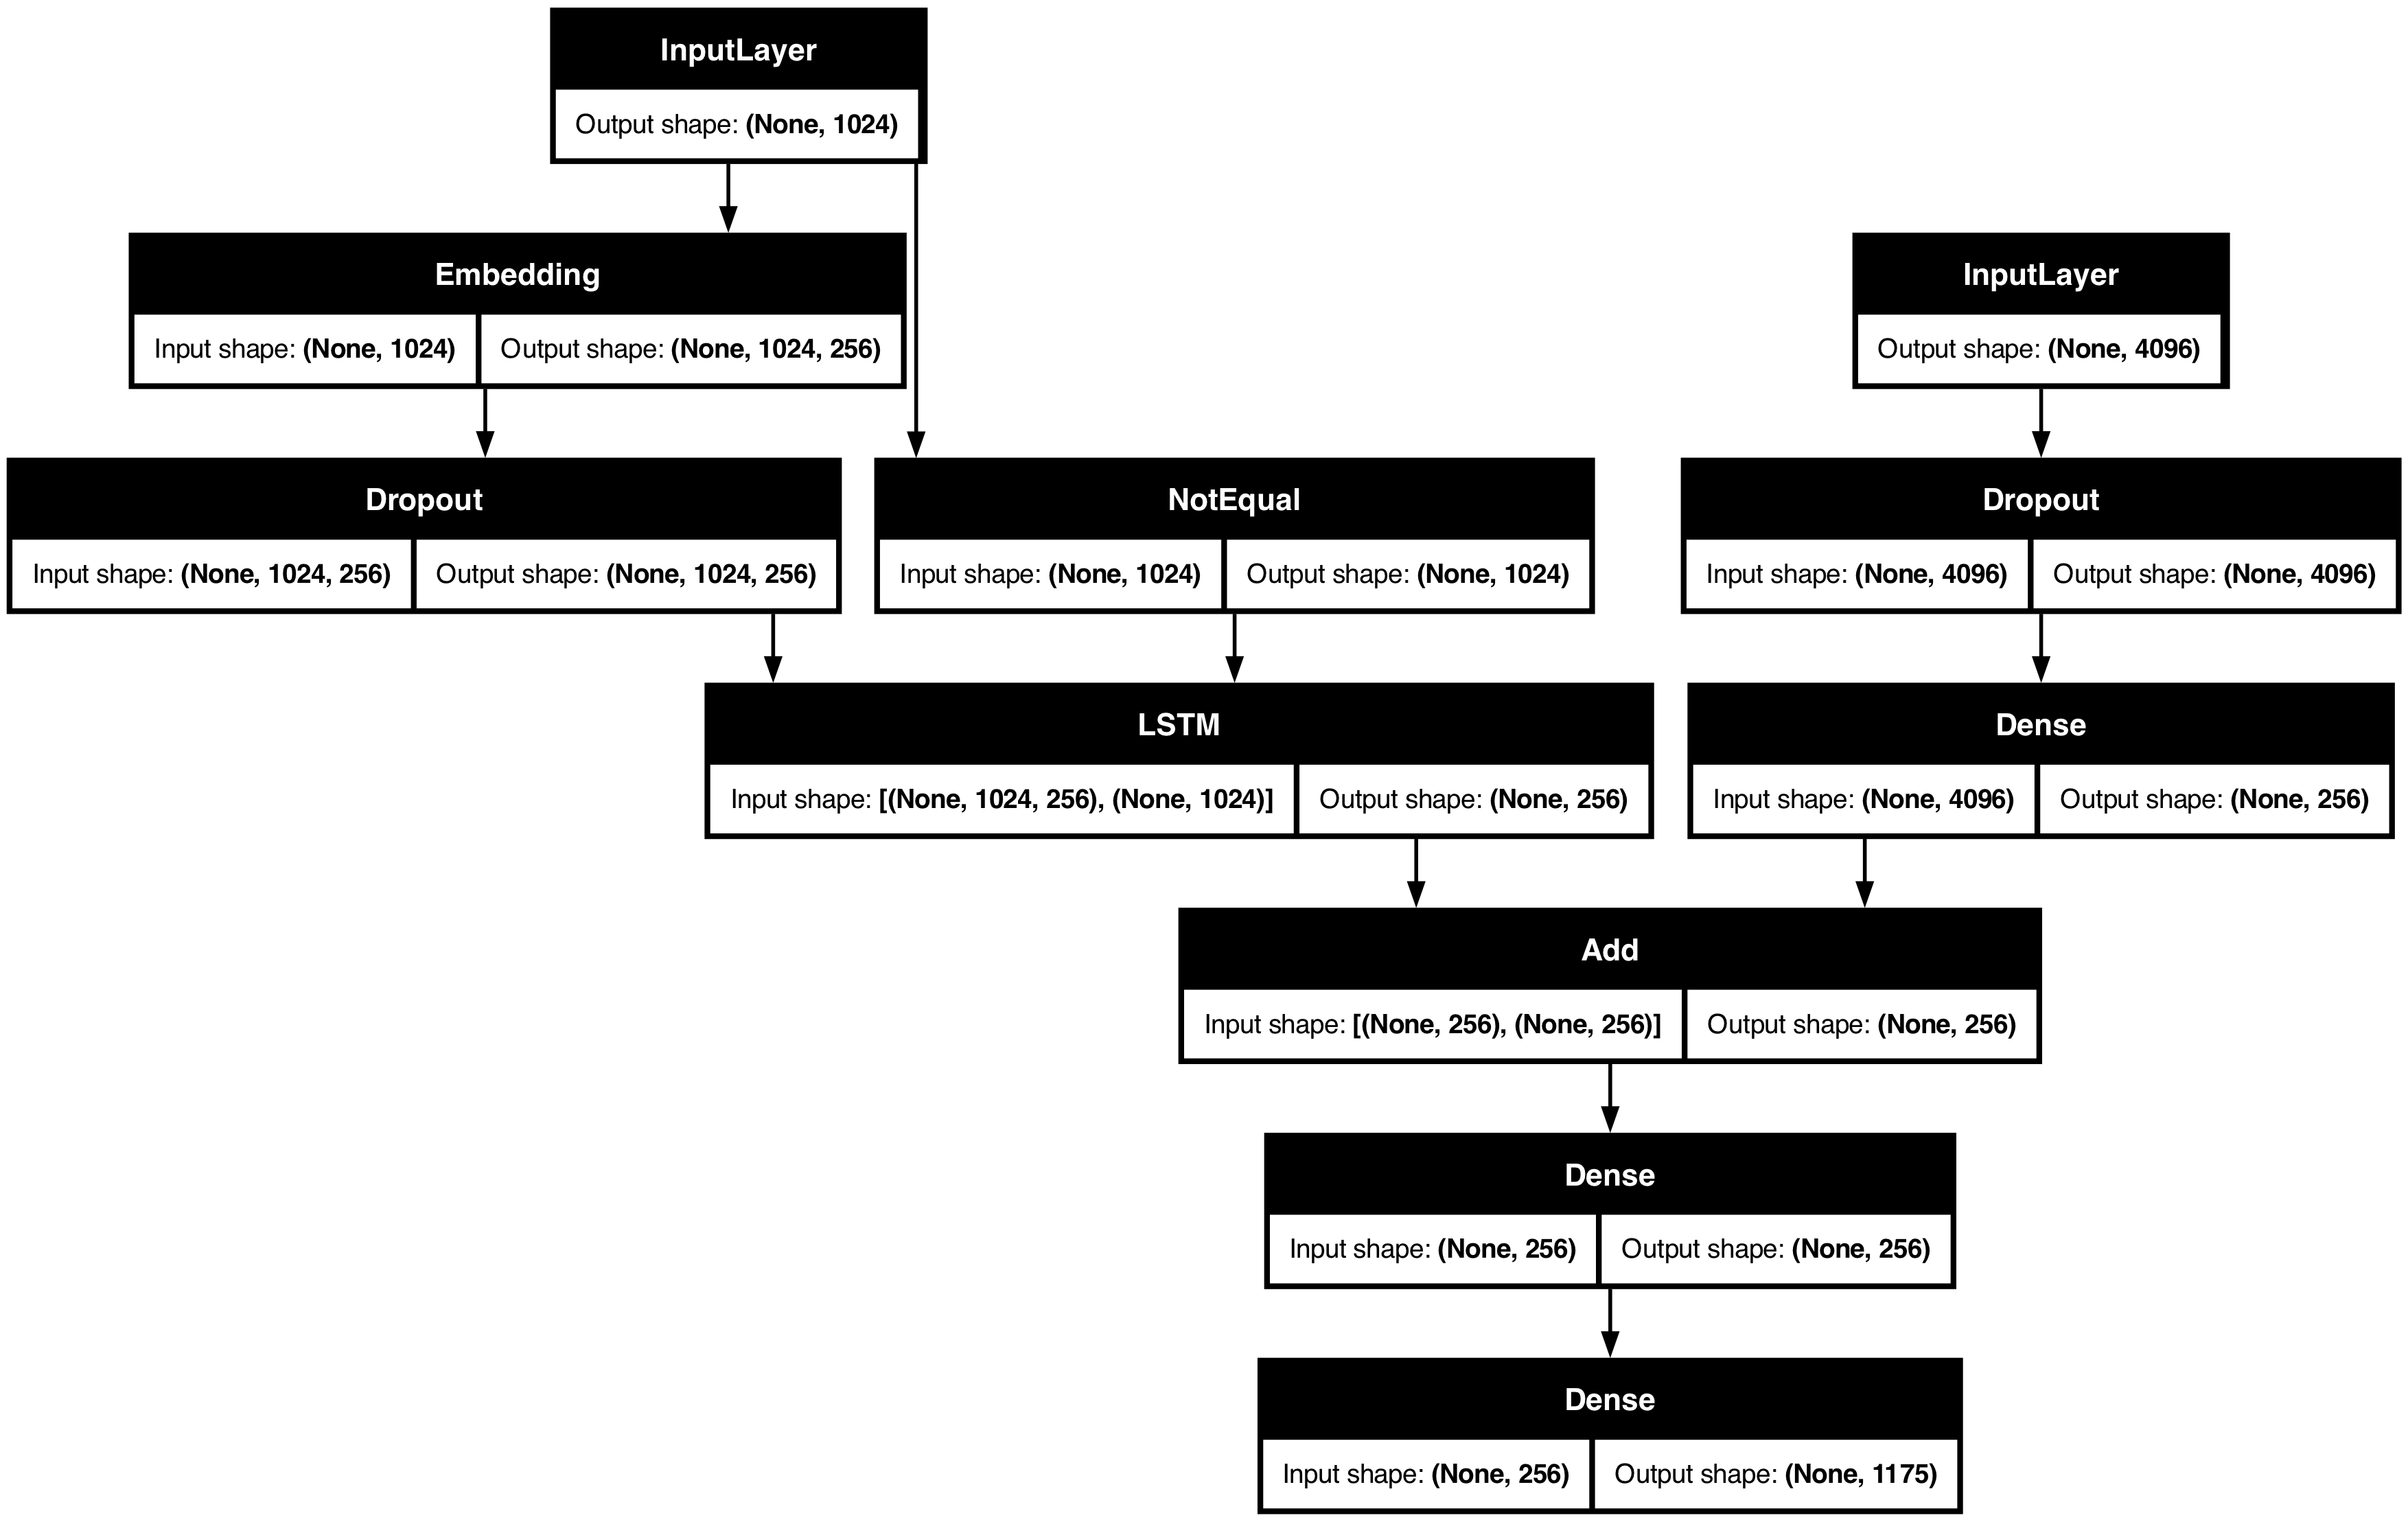

In [17]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(output_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

generation_model = Model(inputs=[inputs1, inputs2], outputs=outputs)
generation_model.compile(loss='categorical_crossentropy', optimizer='adam',  metrics=["accuracy"])

# plot the model
plot_model(generation_model, show_shapes=True)

In [26]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            feature_key = key['session_id']
            captions = mapping[key['session_id']]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    #print([key])
                    X1.append(features[feature_key])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                yield (np.asarray(X1), np.asarray(X2)), np.asarray(y)

In [27]:
mapping = {key['session_id']: normalize_text(key['explanation']) for key in entire_df}

In [ ]:
if glob.glob(saved_path + 'model_generation.h5'):
    print('Loading generation_model.h5')
    generation_model.load_weights(saved_path + 'model_generation.h5')
else:
    # train the model
    batch_size = 32
    steps = len(train) // batch_size
    
    train_generator = data_generator(train, mapping, features, tokenizer, output_length, vocab_size, batch_size)
    val_generator = data_generator(val, mapping, features, tokenizer, output_length, vocab_size, batch_size)
    # fit for 10 epoch
    generation_model.fit(train_generator, epochs=epochs, validation_data=val_generator, steps_per_epoch=steps, verbose=1)
    generation_model.save(saved_path+'model_generation.h5')

In [ ]:
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()
all_captions = []

for key in tqdm(test):
    # get actual caption
    feature_key = key.split('.')[0]
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(generation_model, features[feature_key], tokenizer, output_length)
    all_captions.append(y_pred)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
print(all_captions[0]) 

# Merging of the proposed methods

In [ ]:
def plot_grad_cam_explanation(image, label, pred, heatmap, mask, caption, alpha=128):
	"""
	Plots model input image, Grad-CAM heatmap, segmentation mask and the explanation generated
	Args:
		image (numpy.ndarray): the input 3D image.
		label (int): the input image label.
		pred (int): model prediction for input image.
		heatmap (numpy.ndarray): the Grad-CAM 3D heatmap.
		mask (numpy.ndarray): the computed 3D segmentation mask.
		caption (string): the explanation generated caption.
		alpha (int): transparency channel. Between 0 and 255.
	Returns:
		None.
	"""
	if alpha >= 0 and alpha <= 255:
		heatmap_mask = np.zeros((image.shape[0], image.shape[1], image.shape[2], 4), dtype='uint8')
		heatmap_mask[mask == 1] = [255, 0, 0, alpha]
		image = image[:,:,int(image.shape[2] / 2)]
		heatmap = heatmap[:,:,int(heatmap.shape[2] / 2)]
		heatmap_mask = heatmap_mask[:,:,int(heatmap_mask.shape[2] / 2),:]
		fig, axs = plt.subplots(1, 3, figsize=(18, 6))
		norm_img = cv2.normalize(image, np.zeros((image.shape[1], image.shape[0])), 0, 1, cv2.NORM_MINMAX)
		im_shows = [
			axs[0].imshow(norm_img, cmap='gray', interpolation='bilinear', vmin = .0, vmax = 1.),
			axs[1].imshow(heatmap, cmap='jet', interpolation='bilinear', vmin = .0, vmax = 1.),
			axs[2].imshow(norm_img, cmap='gray', interpolation='bilinear', vmin = .0, vmax = 1.)
		]
		axs[2].imshow(heatmap_mask, interpolation='bilinear')
		axs[0].set_title('Label=' + ('NON-AD' if label == 0 else 'AD') + ' | Prediction=' + ('NON-AD' if pred == 0 else 'AD'), fontsize=16)
		axs[1].set_title('Grad-CAM Heatmap', fontsize=16)
		axs[2].set_title('Mask - Threshold ' + str(.8), fontsize=16)
		for i, ax in enumerate(axs):
			ax.axis('off')
			fig.colorbar(im_shows[i], ax=ax, ticks=np.linspace(0,1,6))
            
        # insert of caption generated
        fig.text(0.5, 0.04, caption, ha='center', va='center')
        fig.tight_layout()
        plt.show()
    else:
		print('\n' + ''.join(['> ' for i in range(30)]))
		print('\nERROR: alpha channel \033[95m '+alpha+'\033[0m out of range [0,255].\n')
		print(''.join(['> ' for i in range(30)]) + '\n')

In [ ]:
def get_results_and_plot(image_dict, predictor, generator,saved_path, tokenizer, max_length, plot=False):
    '''
    In this function we predict the class of the image after that we
    keep the Grad-CAM and the explanation and return them
    :param plot: if True we plot the Grad-CAM and explanation
    :param saved_path: directory where the model weights are stored
    :param image_dict: image dictionary
    :param predictor: model for predict all value
    :param generator: model for the generation of explanation
    :param tokenizer: tokenizer object
    :param max_length: maximum length of explanation
    :return: 
    '''
    
    # Keep the image, the mask and the prediction
    image, mask, pred, label, heatmap = get_gradcam(
        example=image_dict,
        model=predictor,
        saved_path=saved_path,
        threshold=.8,
    )
    
    # Generate the description from the processed image
    explanation = predict_caption(generator, image, tokenizer, max_length)
    
    if plot:
        plot_grad_cam_explanation(image, label, pred, heatmap, mask, explanation)
    
    return  image, label, pred, heatmap, mask, explanation

In [ ]:
# get a random example from the entire dataset
example = entire_df[random.randint(0, entire_df.shape[0]-1)]
get_results_and_plot(
    image_dict=example,
    predictor=densenet,
    generator=generation_model,
    saved_path=saved_path,
    tokenizer=tokenizer,
    max_length=output_length,
    plot=True
)